# Wrangle Review Data

In [1]:
import numpy as np
import pandas as pd
import datetime
import json

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

TITLE_FONT_SIZE = 25
LABEL_FONT_SIZE = 15
TICK_FONT_SIZE  = 15

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

def time_marker(text=''):
    print('[{}] {}'.format(datetime.datetime.now().time(), text.lower()))

# Load Cleaned Business Data

In [3]:
business_data = pd.read_csv('../clean_data/business_clean.csv', index_col=0)
restaurant_bids = list(business_data.business_id.values)

## Load Review Data for Arizona Restaurants
<p>use the list of restaurant_bids provided by the cleaned business data file</p>
<p><b>WARNING THIS TAKES ROUGHLY 25 MINUTES</b></p>

In [16]:
source_data_file = '../source_data/review.json'


# read the file line by line and save only lines we need
restaurant_reviews = []
with open(source_data_file, 'r') as review_file:
    for i, review_json in enumerate(review_file):
        review = json.loads(review_json)
        
        if review['business_id'] not in restaurant_bids:
            pass
        else:
            restaurant_reviews.append(review)

        if i % 100000 == 0:
            time_marker('\tfound {:d}/{:d} restaurant reviews so far {:2.4f} '.format(len(restaurant_reviews),i,len(restaurant_reviews)/(i+1)*100.))

        if i % 1000000 == 0 or i == 0:
            time_marker('processed {:d} reviews so far...'.format(i))

reviews_df = pd.DataFrame(restaurant_reviews)
print('Found {:d} restaurant reviews'.format(reviews_df.shape[0]))

[00:11:51.894528] 	found 0/0 restaurant reviews so far 0.0000 
[00:11:51.894672] processed 0 reviews so far...
[00:11:54.384594] 	found 1252/10000 restaurant reviews so far 12.5187 
[00:11:56.731538] 	found 2777/20000 restaurant reviews so far 13.8843 
[00:11:59.129456] 	found 4035/30000 restaurant reviews so far 13.4496 
[00:12:01.604114] 	found 5173/40000 restaurant reviews so far 12.9322 
[00:12:04.043036] 	found 6564/50000 restaurant reviews so far 13.1277 
[00:12:06.423678] 	found 7901/60000 restaurant reviews so far 13.1681 
[00:12:09.043650] 	found 9146/70000 restaurant reviews so far 13.0655 
[00:12:11.266566] 	found 10221/80000 restaurant reviews so far 12.7761 
[00:12:13.562341] 	found 11462/90000 restaurant reviews so far 12.7354 
[00:12:15.867784] 	found 12635/100000 restaurant reviews so far 12.6349 
[00:12:15.867917] processed 100000 reviews so far...
[00:12:18.246866] 	found 13832/110000 restaurant reviews so far 12.5744 
[00:12:20.571974] 	found 15188/120000 restaurant 

[00:16:09.488055] 	found 131808/1050000 restaurant reviews so far 12.5531 
[00:16:12.865039] 	found 132972/1060000 restaurant reviews so far 12.5445 
[00:16:16.063346] 	found 134304/1070000 restaurant reviews so far 12.5518 
[00:16:18.350562] 	found 135599/1080000 restaurant reviews so far 12.5555 
[00:16:20.850549] 	found 136868/1090000 restaurant reviews so far 12.5567 
[00:16:25.196203] 	found 137916/1100000 restaurant reviews so far 12.5378 
[00:16:25.196313] processed 1100000 reviews so far...
[00:16:31.875704] 	found 139218/1110000 restaurant reviews so far 12.5422 
[00:16:35.841692] 	found 140464/1120000 restaurant reviews so far 12.5414 
[00:16:38.174958] 	found 141658/1130000 restaurant reviews so far 12.5361 
[00:16:40.966787] 	found 142818/1140000 restaurant reviews so far 12.5279 
[00:16:45.419866] 	found 144004/1150000 restaurant reviews so far 12.5221 
[00:16:47.869612] 	found 145348/1160000 restaurant reviews so far 12.5300 
[00:16:50.562053] 	found 146580/1170000 restau

[00:20:49.549623] 	found 258556/2080000 restaurant reviews so far 12.4306 
[00:20:51.955398] 	found 259854/2090000 restaurant reviews so far 12.4332 
[00:20:54.789340] 	found 261034/2100000 restaurant reviews so far 12.4302 
[00:20:54.789457] processed 2100000 reviews so far...
[00:20:57.353584] 	found 262370/2110000 restaurant reviews so far 12.4346 
[00:20:59.637559] 	found 263736/2120000 restaurant reviews so far 12.4404 
[00:21:01.922114] 	found 264970/2130000 restaurant reviews so far 12.4399 
[00:21:04.361620] 	found 266118/2140000 restaurant reviews so far 12.4354 
[00:21:06.878036] 	found 267438/2150000 restaurant reviews so far 12.4390 
[00:21:09.397795] 	found 268743/2160000 restaurant reviews so far 12.4418 
[00:21:11.968815] 	found 269811/2170000 restaurant reviews so far 12.4337 
[00:21:14.330233] 	found 271002/2180000 restaurant reviews so far 12.4313 
[00:21:17.068858] 	found 272420/2190000 restaurant reviews so far 12.4393 
[00:21:19.500479] 	found 273610/2200000 restau

[00:26:30.412642] 	found 384795/3110000 restaurant reviews so far 12.3728 
[00:26:33.631575] 	found 385866/3120000 restaurant reviews so far 12.3675 
[00:26:36.950977] 	found 387069/3130000 restaurant reviews so far 12.3664 
[00:26:41.004254] 	found 388585/3140000 restaurant reviews so far 12.3753 
[00:26:44.349116] 	found 389717/3150000 restaurant reviews so far 12.3720 
[00:26:47.224074] 	found 391105/3160000 restaurant reviews so far 12.3767 
[00:26:50.175683] 	found 392242/3170000 restaurant reviews so far 12.3736 
[00:26:52.972100] 	found 393594/3180000 restaurant reviews so far 12.3772 
[00:26:55.835494] 	found 394754/3190000 restaurant reviews so far 12.3747 
[00:26:58.811075] 	found 395941/3200000 restaurant reviews so far 12.3732 
[00:26:58.811250] processed 3200000 reviews so far...
[00:27:01.905865] 	found 397113/3210000 restaurant reviews so far 12.3711 
[00:27:04.836169] 	found 398196/3220000 restaurant reviews so far 12.3663 
[00:27:07.987095] 	found 399451/3230000 restau

[00:31:57.576953] 	found 511060/4140000 restaurant reviews so far 12.3444 
[00:32:02.577276] 	found 512437/4150000 restaurant reviews so far 12.3479 
[00:32:05.859573] 	found 513702/4160000 restaurant reviews so far 12.3486 
[00:32:09.553646] 	found 515022/4170000 restaurant reviews so far 12.3506 
[00:32:12.630973] 	found 516241/4180000 restaurant reviews so far 12.3503 
[00:32:16.255242] 	found 517217/4190000 restaurant reviews so far 12.3441 
[00:32:20.153487] 	found 518252/4200000 restaurant reviews so far 12.3393 
[00:32:20.153607] processed 4200000 reviews so far...
[00:32:23.317292] 	found 519720/4210000 restaurant reviews so far 12.3449 
[00:32:26.372185] 	found 520837/4220000 restaurant reviews so far 12.3421 
[00:32:29.340080] 	found 521970/4230000 restaurant reviews so far 12.3397 
[00:32:32.605975] 	found 523128/4240000 restaurant reviews so far 12.3379 
[00:32:36.009474] 	found 524257/4250000 restaurant reviews so far 12.3355 
[00:32:38.890005] 	found 525603/4260000 restau

[00:38:09.896631] 	found 639382/5170000 restaurant reviews so far 12.3672 
[00:38:13.471939] 	found 640449/5180000 restaurant reviews so far 12.3639 
[00:38:16.913590] 	found 641919/5190000 restaurant reviews so far 12.3684 
[00:38:20.795772] 	found 643121/5200000 restaurant reviews so far 12.3677 
[00:38:20.795921] processed 5200000 reviews so far...
[00:38:24.205881] 	found 644367/5210000 restaurant reviews so far 12.3679 
[00:38:27.502986] 	found 645596/5220000 restaurant reviews so far 12.3677 
[00:38:30.515948] 	found 646879/5230000 restaurant reviews so far 12.3686 
[00:38:33.554355] 	found 648170/5240000 restaurant reviews so far 12.3697 
[00:38:36.789775] 	found 649459/5250000 restaurant reviews so far 12.3706 
[00:38:39.973885] 	found 650607/5260000 restaurant reviews so far 12.3690 
Found 650805 restaurant reviews


In [17]:
reviews_df.head().transpose()

,0,1,2,3,4
business_id,JlNeaOymdVbE6_bubqjohg,0Rni7ocMC_Lg2UH0lDeKMQ,S-oLPRdhlyL5HAknBKTUcQ,iIjVO7cLD1UEmIO7G05Ujw,1JF9TbJ2d5hH8xsQvvklHg
cool,0,0,0,0,0
date,2014-08-09,2014-08-09,2017-11-30,2016-06-11,2016-06-18
funny,0,0,0,0,0
review_id,BF0ANB54sc_f-3_howQBCg,DbLUpPT61ykLTakknCF9CQ,z_mVLygzPn8uHp63SSCErw,xatycgntu_F_Ioyny3iflw,Z7U7MMef6Tbj_ZbSFzLRUw
stars,1,1,4,4,5
text,We always go to the chevo's in chandler which ...,"This place is always so dirty and grimy, been ...",Holy portion sizes! You get a lot of bang for ...,Flavor was actually pretty good. Not used to e...,This is place very great flavor. Server was on...
useful,3,6,0,0,1
user_id,ssuXFjkH4neiBgwv-oN4IA,ssuXFjkH4neiBgwv-oN4IA,MzEnYCyZlRYQRISNMXTWIg,vaXJ7-xLrnD6FAEhUqYKwQ,vaXJ7-xLrnD6FAEhUqYKwQ


In [18]:
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 650805 entries, 0 to 650804
Data columns (total 9 columns):
business_id    650805 non-null object
cool           650805 non-null int64
date           650805 non-null object
funny          650805 non-null int64
review_id      650805 non-null object
stars          650805 non-null int64
text           650805 non-null object
useful         650805 non-null int64
user_id        650805 non-null object
dtypes: int64(4), object(5)
memory usage: 44.7+ MB


In [20]:
reviews_df.describe()

,cool,funny,stars,useful
count,650805.000000,650805.000000,650805.000000,650805.000000
mean,0.585029,0.544939,3.747404,1.231779
std,2.782319,5.570427,1.395627,9.327985
min,-1.000000,0.000000,1.000000,-1.000000
25%,0.000000,0.000000,3.000000,0.000000
50%,0.000000,0.000000,4.000000,0.000000
75%,1.000000,0.000000,5.000000,1.000000
max,1105.000000,1481.000000,5.000000,3364.000000


# Sanitize Review Text for CSV

In [58]:
reviews_df['text'] = reviews_df.text.apply(lambda x: x.replace(',', ''))

# Write to File
<p>Write data frame of only Arizona Restaurant reviews to file</p>

In [60]:
file_name = '../clean_data/az_restaurant_reviews.csv'
time_marker(text='Writing {:d} records to file {}'.format(reviews_df.shape[0], file_name))
reviews_df.to_csv(file_name, encoding='utf-8')
time_marker('complete!')

[01:10:42.279041] writing 650805 records to file ../clean_data/az_restaurant_reviews.csv
[01:11:02.856439] complete!


## SpaCy Exploration

In [43]:
import spacy
nlp = spacy.load('en')

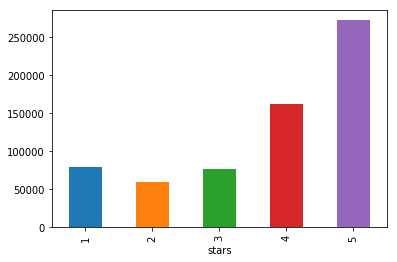

In [69]:
reviews_df.groupby('stars').count()['review_id'].plot(kind='bar')
plt.show()
plt.close()

In [71]:
reviews_df[reviews_df.text.str.len() == reviews_df.text.str.len().median()]

,business_id,cool,date,funny,review_id,stars,text,useful,user_id
189,utIA0LyQmwP-9DRyxUe6qQ,0,2015-10-15,0,BnAz6rlSRO-QBi8haHSMBw,4,You can't hit the snooze button on a Saturday ...,0,Jt4u7qnfrk35buainfOuGA
198,Lsy_RA1xk9qHFLzLNWKBww,0,2011-05-31,0,Hm8GS7w6DZUKbyKtdD9b6g,5,Pitta Souvli is without a doubt my favorite Gr...,1,Jt4u7qnfrk35buainfOuGA
1343,a1KXovXPdeDurOrER4ST6A,0,2015-05-03,0,ootaS7DQKO8hR4FRx_wAeA,4,Great sushi in an odd and easy to miss locatio...,1,tWJrrj2WUCCU5l6DwvRnOQ
1611,3-6biVwm7VwPZ-k67jml-Q,0,2013-11-20,0,__re5Hffgi76LtJIQceZdg,5,This place is a definite find! Tucked away in ...,1,p7W-M8BdZ1Z_T0jiw1602w
2585,Gh-qmVwvibLnNdqEZXcQHw,0,2015-03-16,0,daTPqnCAkNLPPdaQrbZIfQ,5,Came in for dessert with my daughter today aft...,0,ewtL3plKywXuLtmFZoUczw
2885,UUtWoDyREiy9MPdtTRFUYQ,0,2017-11-27,0,IqJ6HmOIfsaZhncsHZqXxg,1,Very disappointed with this place the food was...,0,BZEFc49mGkFj13n_Gh6vqA
4864,3sOS8wKatd_Uoa9VEJHhrw,0,2016-10-09,0,8z7bvgMIY7Ra-63S5vRXqA,5,This place is really good. If you like a goo...,0,-dtxFhW1uXT2EQ2McGFu7Q
6531,nsNONDHbV7Vudqh21uicqw,2,2009-09-21,1,VhEmqzm6F51Qs15Y8DBHyQ,2,Maybe I'm the fool but I still don't see what ...,4,rwqNgBh1lbHCmWCK6Q1DCg
6532,sQ6DZZLLJRfwUr0eDWKDDg,1,2015-10-25,1,JewKSqeJkSnPr_PPkd1_4A,5,This is a great Asian food diner. We came for...,1,rwqNgBh1lbHCmWCK6Q1DCg
7883,L2p0vO3fsS2LC6hhQo3CzA,0,2014-08-23,0,APVo1ohaO-CeyuRlyp2eBA,2,Breakfast review. Came in when it opened. Wait...,0,_NU6Ua5ifHdVKsXn6ervKQ


In [72]:
neg_review = reviews_df.iloc[2885,:].text
pos_review = reviews_df.iloc[198,:].text

In [73]:
parsed_neg = nlp(neg_review)
parsed_pos = nlp(pos_review)


In [84]:
print(neg_review)
print('='*80)
print()
for num, sentence in enumerate(parsed_neg.sents):
    print('Sentence {}:\t{}'.format(num + 1, sentence))
print('='*80)
print()
for num, entity in enumerate(parsed_neg.ents):
    print('Entity {}: "'.format(num + 1), entity, '" -', entity.label_)

Very disappointed with this place the food was not at all good nor Spicey nor well presented and the server was extremely difficult to communicate with. Our orders were messed up entirely and even though we had a difficult person in our party the whole evening was bad. Won't be going back for sure and if you want real Asian food I suggest you go to an authentic restaurant.

Sentence 1:	Very disappointed with this place the food was not at all good nor Spicey nor well presented and the server was extremely difficult to communicate with.
Sentence 2:	Our orders were messed up entirely and even though we had a difficult person in our party the whole evening was bad.
Sentence 3:	Won't be going back for sure and if you want real Asian food
Sentence 4:	I suggest you go to an authentic restaurant.

Entity 1: " Spicey " - NORP
Entity 2: " the whole evening " - TIME
Entity 3: " Asian " - NORP


In [85]:
print(pos_review)
print('='*80)
print()
for num, sentence in enumerate(parsed_pos.sents):
    print('Sentence {}:\t{}'.format(num + 1, sentence))
print('='*80)
print()
for num, entity in enumerate(parsed_pos.ents):
    print('Entity {}: "'.format(num + 1), entity, '" -', entity.label_)

Pitta Souvli is without a doubt my favorite Greek restaurant in the Valley. It is locally owned has fantastic customer service and the food is amazing. I am a vegetarian and this place always has delicious options for me. However pre-vegetarian days were filled with their tuna salad which is out of this world :) Don't miss out on an order of the greek fries when you visit!

Sentence 1:	Pitta Souvli is without a doubt my favorite Greek restaurant in the Valley.
Sentence 2:	It is locally owned has fantastic customer service and the food is amazing.
Sentence 3:	I am a vegetarian and this place always has delicious options for me.
Sentence 4:	However pre-vegetarian days were filled with their tuna salad which is out of this world :)
Sentence 5:	Don't miss out on an order of the greek fries when you visit!

Entity 1: " Pitta Souvli " - PERSON
Entity 2: " Greek " - NORP
Entity 3: " Valley " - LOC


In [90]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

from collections import Counter

In [91]:
pos_review_counter = Counter(word_tokenize(pos_review))
neg_review_counter = Counter(word_tokenize(neg_review))

In [92]:
tokens = [w for w in word_tokenize(pos_review.lower()) if w.isalpha()]
no_stops = [t for t in tokens if t not in stopwords.words('english')]

In [93]:
print('Original Text    {}'.format(pos_review))
print('Tokens           {}'.format(tokens))
print('No Stop Words    {}'.format(no_stops))
print('Two most common  {}'.format(Counter(no_stops).most_common(2)))

Original Text    Pitta Souvli is without a doubt my favorite Greek restaurant in the Valley. It is locally owned has fantastic customer service and the food is amazing. I am a vegetarian and this place always has delicious options for me. However pre-vegetarian days were filled with their tuna salad which is out of this world :) Don't miss out on an order of the greek fries when you visit!
Tokens           ['pitta', 'souvli', 'is', 'without', 'a', 'doubt', 'my', 'favorite', 'greek', 'restaurant', 'in', 'the', 'valley', 'it', 'is', 'locally', 'owned', 'has', 'fantastic', 'customer', 'service', 'and', 'the', 'food', 'is', 'amazing', 'i', 'am', 'a', 'vegetarian', 'and', 'this', 'place', 'always', 'has', 'delicious', 'options', 'for', 'me', 'however', 'days', 'were', 'filled', 'with', 'their', 'tuna', 'salad', 'which', 'is', 'out', 'of', 'this', 'world', 'do', 'miss', 'out', 'on', 'an', 'order', 'of', 'the', 'greek', 'fries', 'when', 'you', 'visit']
No Stop Words    ['pitta', 'souvli', 'wi

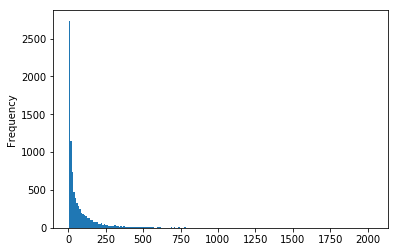

In [97]:
reviews_df.groupby('business_id').count()['review_id'].plot(kind='hist', bins=200)
plt.show()
plt.close()

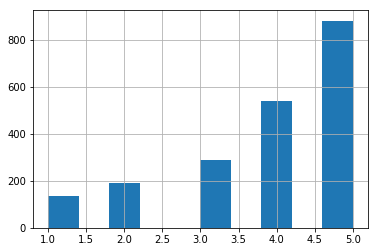

In [112]:
reviews_df[reviews_df.business_id == 'pSQFynH1VxkfSmehRXlZWw'].stars.hist()
plt.show()
plt.close()

In [ ]:
data = pd.DataFrame()
source_data_file = '../source_data/tip.json'

time_marker('loading source data file...')
biz_list = []
for line in open(source_data_file, 'r'):
    biz_list.append(json.loads(line))

time_marker('creating dataframe...')
data = pd.DataFrame(biz_list)

In [ ]:
data.info()

## Prune tips to only those for our restaurant subset

In [ ]:
data = data[data.business_id.isin(restaurant_bids)].copy()
data.reset_index(inplace=True, drop=True)

In [ ]:
time_marker(text='set index to business_id...')
data.set_index('business_id', inplace=True, drop=True)

## Prune tips that are less than less than 4 characters long, these rarely provide useful information

In [ ]:
data = data[data.text.str.len() >= 4].copy()

## Sanitize tip text

In [ ]:
import string
translator = str.maketrans('','', string.punctuation)

In [ ]:
data['text'] = data['text'].apply(lambda text: text.translate(translator).lower())

## Cleanup columns and reset index

In [ ]:
time_marker(text='cleaning up and reset index...')
data.columns = [str(x).lower().replace(' ', '_') for x in data.columns]
data.reset_index(inplace=True)

## EDA Tip Text Length Distribution

In [ ]:
ax = data.text.str.len().plot(kind='hist', bins=200, figsize=(15,6))

ax.axvline(data.text.str.len().quantile(0.05), color='k')
ax.axvline(data.text.str.len().quantile(0.25), color='k', alpha=0.5, linestyle=':')
ax.axvline(data.text.str.len().quantile(0.55), color='k', alpha=0.5, linestyle=':')
ax.axvline(data.text.str.len().quantile(0.75), color='k', alpha=0.5, linestyle=':')
ax.axvline(data.text.str.len().quantile(0.95), color='k')

plt.show()
plt.close()

## Tokenize Tip Text, remove stop words

In [ ]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

In [ ]:
def tokenize_tip(text):
    tokens = [t for t in word_tokenize(text) if t.isalpha()]
    no_stops = [t for t in tokens if t not in stopwords.words('english')]
    return no_stops

In [ ]:
data['tokenize_text'] = data.text.apply(lambda x: tokenize_tip(x))

In [ ]:
data['word_count'] = data.tokenize_text.str.len()

In [ ]:
data['unique_word_count'] = data.tokenize_text.apply(lambda x: len(set(x)))

In [ ]:
data.head(3).transpose()

## EDA Tip Word Count Distribution

In [ ]:
ax = data.word_count.plot(kind='hist', bins=100, figsize=(15,6))

ax.axvline(data.word_count.quantile(0.05), color='k')
ax.axvline(data.word_count.quantile(0.25), color='k', alpha=0.5, linestyle=':')
ax.axvline(data.word_count.quantile(0.55), color='k', alpha=0.5, linestyle=':')
ax.axvline(data.word_count.quantile(0.75), color='k', alpha=0.5, linestyle=':')
ax.axvline(data.word_count.quantile(0.95), color='k')

plt.show()
plt.close()

In [ ]:
data.head()

In [ ]:
data_pruned = data[(data.unique_word_count > 3) & (data.text.str.len() > 10)].copy()

data_pruned.head().transpose()

In [ ]:
ax = data_pruned.word_count.plot(kind='hist', bins=100, figsize=(15,6))

ax.axvline(data_pruned.word_count.quantile(0.05), color='k')
ax.axvline(data_pruned.word_count.quantile(0.25), color='k', alpha=0.5, linestyle=':')
ax.axvline(data_pruned.word_count.quantile(0.55), color='k', alpha=0.75, linestyle='-.')
ax.axvline(data_pruned.word_count.quantile(0.75), color='k', alpha=0.5, linestyle=':')
ax.axvline(data_pruned.word_count.quantile(0.95), color='k')

plt.show()
plt.close()

In [ ]:
data.info()

In [ ]:
data_pruned.info()

# Write to File

In [ ]:
# file_name = '../clean_data/business_clean.csv'
# time_marker(text='Writing {:d} records to file {}'.format(data_pass3.shape[0], file_name))
# data_pass3.to_csv(file_name, encoding='utf-8')